<a href="https://colab.research.google.com/github/ChangCorp/finalproject/blob/main/Stage_3_Chang_Corp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df_train = pd.read_csv('/content/pca_df_train.csv')
df_test = pd.read_csv('/content/pca_df_test.csv')

In [3]:
df_train.head()

,PC1,PC2,PC3,PC4,PC5,subscribed
0,0.596122,1.692250,1.612440,-1.489756,-1.146045,0
1,0.970401,-1.458629,-0.767858,0.746759,0.425969,0
2,1.119080,-0.816684,-0.316655,-0.136146,-0.778940,0
3,0.989258,0.081316,-1.214012,1.065514,-0.634280,0
4,0.988899,-1.968612,-0.231976,0.750177,0.879801,0


# Modeling

Data input berupa data langsung hasil olahan PCA, untuk modeling data tanpa menggunakan PCA sudah dilakukan pada proyek rumpang.

In [3]:
import warnings
warnings.filterwarnings('ignore')

SPLIT X AND Y

definisikan variabel baru x dan y dimana x adalah semua kolom fitur dan y adalah semua kolom target

In [4]:
X_train_pca = df_train.drop(columns='subscribed')
y_train_pca = df_train['subscribed']

X_test_pca = df_test.drop(columns='subscribed')
y_test_pca = df_test['subscribed']

In [5]:
#Tidak perlu menggunakan ini karena data sudah terpisah sejak awal
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_train_pca, y_train_pca, test_size=0.2, random_state=42)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

X_train = X_train_pca
y_train = y_train_pca
X_test  = X_test_pca
y_test  = y_test_pca

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

## Decision Tree

Decision Tree

Menggunakan model ML Decision Tree, tampilkan hasil classification pertamanya.

In [9]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Evaluasi
eval_classification(dt)

Accuracy (Test Set): 0.70
Precision (Test Set): 0.17
Recall (Test Set): 0.43
F1-Score (Test Set): 0.25
roc_auc (test-proba): 0.58
roc_auc (train-proba): 1.00


Terlihat model overfit. Akan coba dilakukan hyperparameter tuning

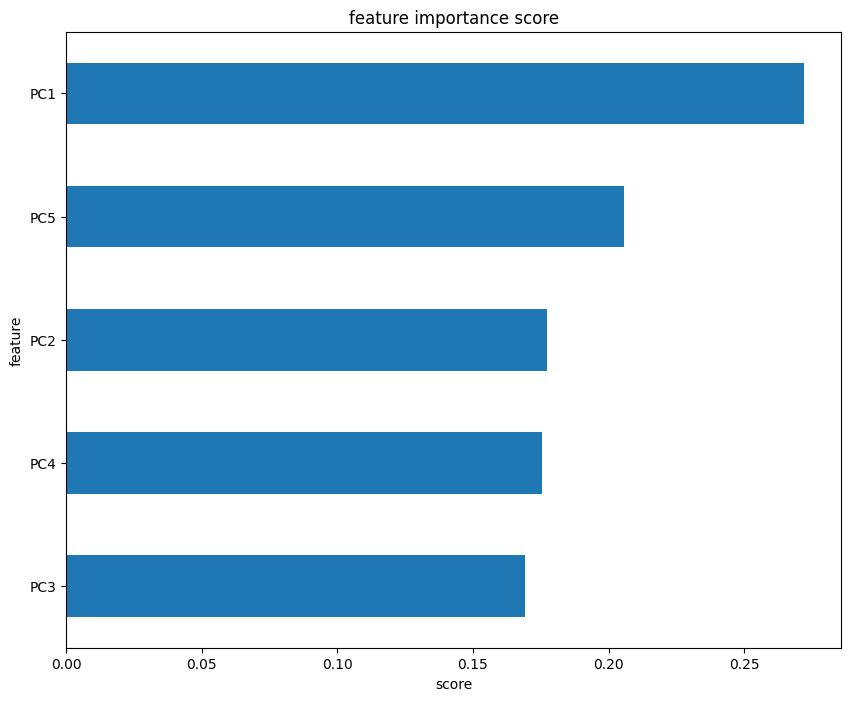

In [12]:
show_feature_importance(dt)

RUMPANG 14 = HYPERPARAMETER

Perbaiki model Decision Tree yang overfit dengan :

1. parameter maksimal  = auto dan sqrt
2. menggunakan cv sebesar 5
3. menggunakan "recall" sebagai scoring

In [13]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
# max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
# min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
# min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
# max_features = ['auto', 'sqrt'] # Number of features to consider at every split
# criterion = ['gini','entropy']
# splitter = ['best','random']

max_depth = [int(x) for x in np.linspace(10, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [50, 100] # Minimum number of samples required to split a node
min_samples_leaf = [10, 20, 50] # Minimum number of samples required at each leaf node
max_features = [ 'auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']


hyperparameters = dict(max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt_ht = DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt_ht, hyperparameters, cv=5, scoring='recall', random_state=42)
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.44
Recall (Test Set): 0.10
F1-Score (Test Set): 0.17
roc_auc (test-proba): 0.60
roc_auc (train-proba): 0.90


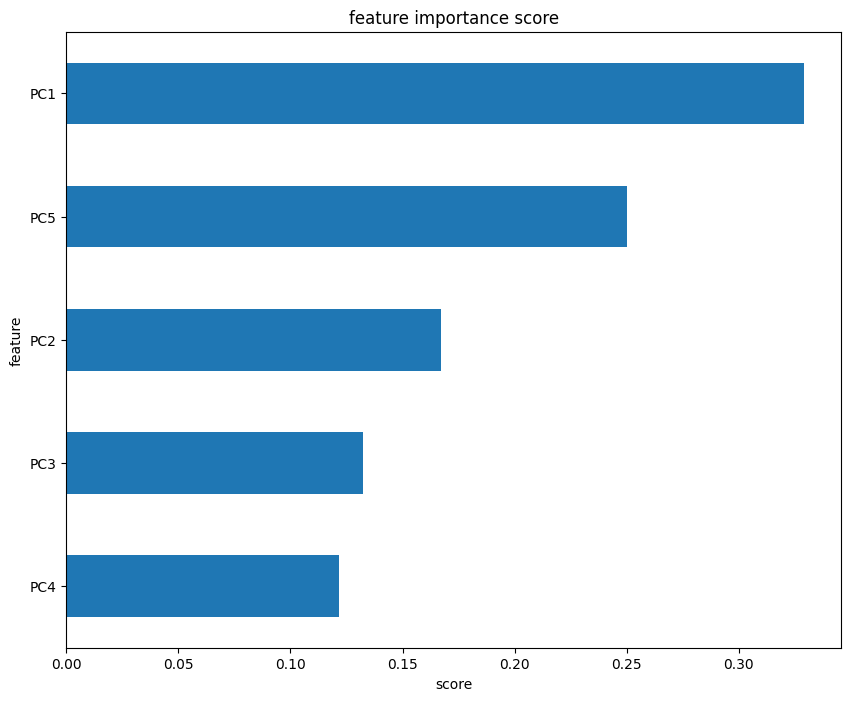

In [14]:
show_feature_importance(model.best_estimator_)

Model tidak lagi overfit, tetapi nilai Recall menurun

## Random Forest

RUMPANG 15 : Random Forest

Menggunakan model ML Random Forest, tampilkan hasil classification pertamanya.

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluasi
eval_classification(rf)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.59
Recall (Test Set): 0.17
F1-Score (Test Set): 0.26
roc_auc (test-proba): 0.65
roc_auc (train-proba): 1.00


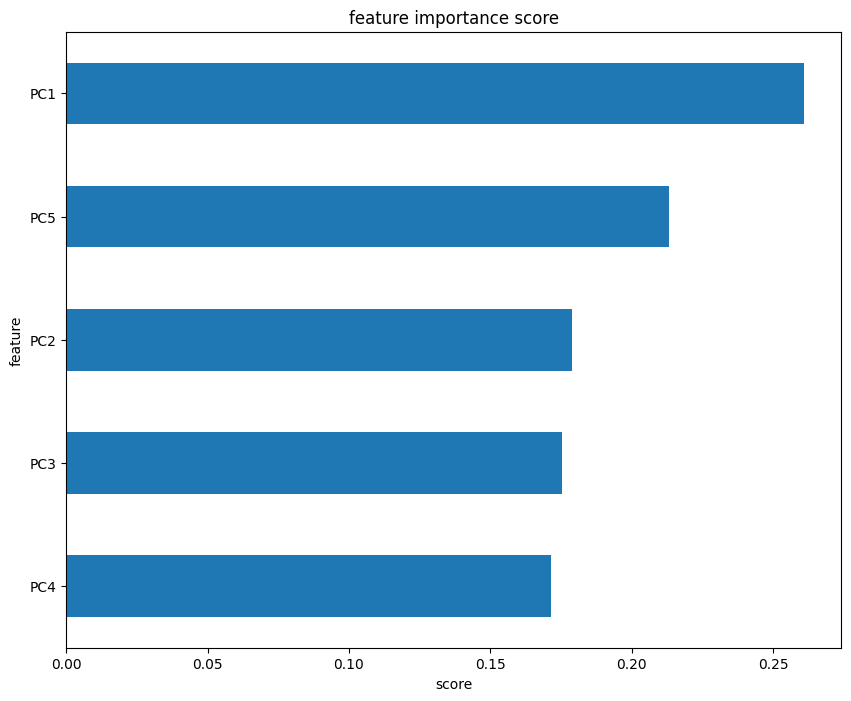

In [16]:
show_feature_importance(rf)

In [20]:
# tuning hyperparameter RF
from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
# criterion = ['gini', 'entropy']
# max_depth = [int(x) for x in np.linspace(2, 100, 50)]
# min_samples_split = [int(x) for x in np.linspace(2, 20, 10)]
# min_samples_leaf = [int(x) for x in np.linspace(2, 20, 10)]
# hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
#                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

n_estimators = [int(x) for x in np.linspace(10, 100, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 50, 10)]
min_samples_split = [int(x) for x in np.linspace(10, 50, 10)]
min_samples_leaf = [int(x) for x in np.linspace(10, 50, 10)]
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf_hp = RandomForestClassifier(random_state=42)
rs_hp = RandomizedSearchCV(rf_hp, hyperparameters, scoring='recall', random_state=42, cv=5)
rs_hp.fit(X_train, y_train)
eval_classification(rs_hp)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.71
Recall (Test Set): 0.15
F1-Score (Test Set): 0.24
roc_auc (test-proba): 0.67
roc_auc (train-proba): 0.92


Hasil hyperparameter tuning --> model tidak overfit, nilai recall turun


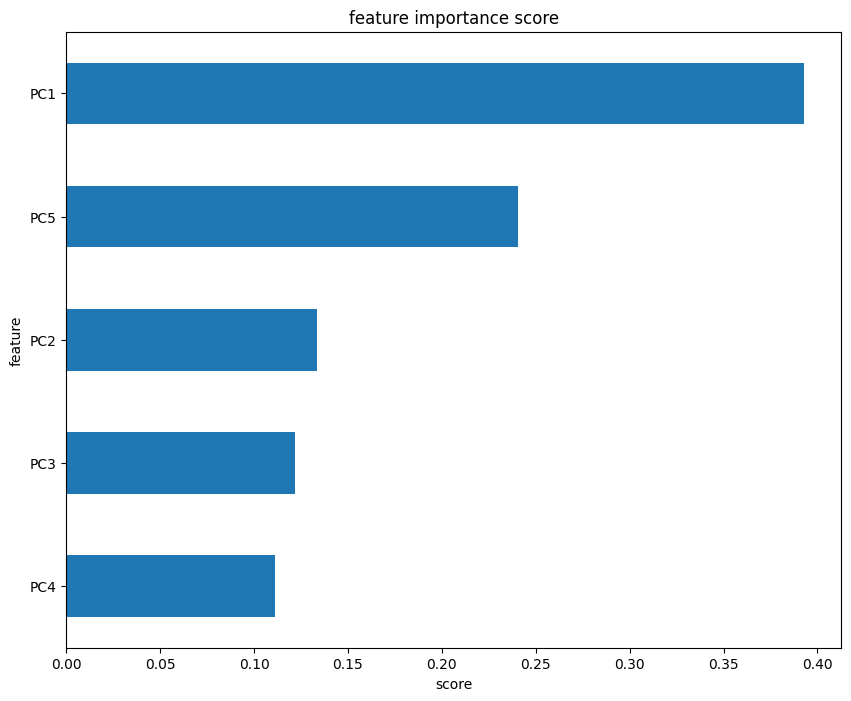

In [21]:
show_feature_importance(rs_hp.best_estimator_)

## Logistic Regression

RUMPANG 16 : Logistic Regression

Menggunakan model ML Logistic Regression, tampilkan hasil classification pertamanya.

In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Evaluasi
eval_classification(logreg)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.60
Recall (Test Set): 0.06
F1-Score (Test Set): 0.11
roc_auc (test-proba): 0.70
roc_auc (train-proba): 0.72


In [26]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.01, 0.05, 200)]
hyperparameters = dict(penalty=penalty, C=C, solver=['sag','saga'])

logreg = LogisticRegression()
rs = RandomizedSearchCV(logreg, hyperparameters, scoring='recall', random_state=42, cv=5, n_iter=50)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.60
Recall (Test Set): 0.06
F1-Score (Test Set): 0.11
roc_auc (test-proba): 0.70
roc_auc (train-proba): 0.72


Hasil hyperparameter tuning --> model tidak overfit, nilai recall turun

## KNN

RUMPANG 17 : KNN

Menggunakan model ML KNN, tampilkan hasil classification pertamanya.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluasi
eval_classification(knn)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.66
Recall (Test Set): 0.14
F1-Score (Test Set): 0.23
roc_auc (test-proba): 0.63
roc_auc (train-proba): 0.92


In [28]:
from sklearn.model_selection import RandomizedSearchCV

n_neighbors = list(range(1,30))
p=[1,2]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights)

knn.fit(X_train, y_train)
rs_knn = RandomizedSearchCV(knn, hyperparameters, scoring='recall', random_state=42, cv=5)
rs_knn.fit(X_train, y_train)
eval_classification(rs_knn)

Accuracy (Test Set): 0.83
Precision (Test Set): 0.26
Recall (Test Set): 0.25
F1-Score (Test Set): 0.26
roc_auc (test-proba): 0.60
roc_auc (train-proba): 1.00


Hasil hyperparameter tuning --> model overfit, nilai recall meningkat

## Naive Bayes

RUMPANG 18 : Naive Bayes

Menggunakan model ML Naive Bayes, tampilkan hasil classification pertamanya.

In [29]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluasi
eval_classification(nb)

Accuracy (Test Set): 0.21
Precision (Test Set): 0.11
Recall (Test Set): 0.84
F1-Score (Test Set): 0.20
roc_auc (test-proba): 0.47
roc_auc (train-proba): 0.69


## XGBoost

RUMPANG 19 : XGBoost

Menggunakan model ML XGBoost, tampilkan hasil classification pertamanya.

In [30]:
from xgboost import XGBClassifier

xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

# Evaluasi
eval_classification(xg)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.68
Recall (Test Set): 0.15
F1-Score (Test Set): 0.25
roc_auc (test-proba): 0.62
roc_auc (train-proba): 0.90


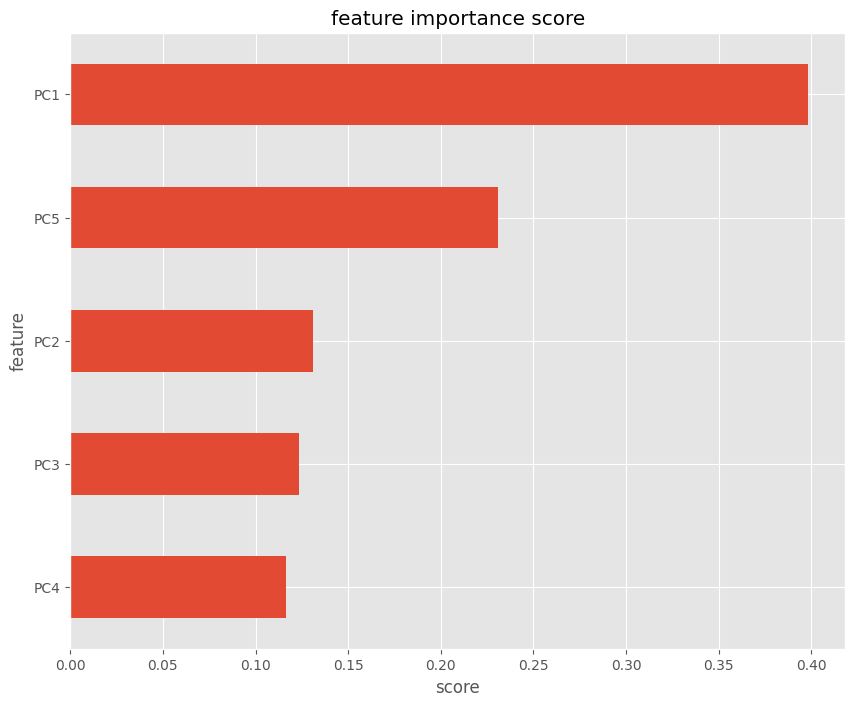

In [31]:
show_feature_importance(xg)

In [32]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(6, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.45
Recall (Test Set): 0.17
F1-Score (Test Set): 0.25
roc_auc (test-proba): 0.56
roc_auc (train-proba): 1.00


Setelah dilakukan hyperparameter tuning dapat dilihat bahwa hasil score meningkat dan tidak terjadi overfit

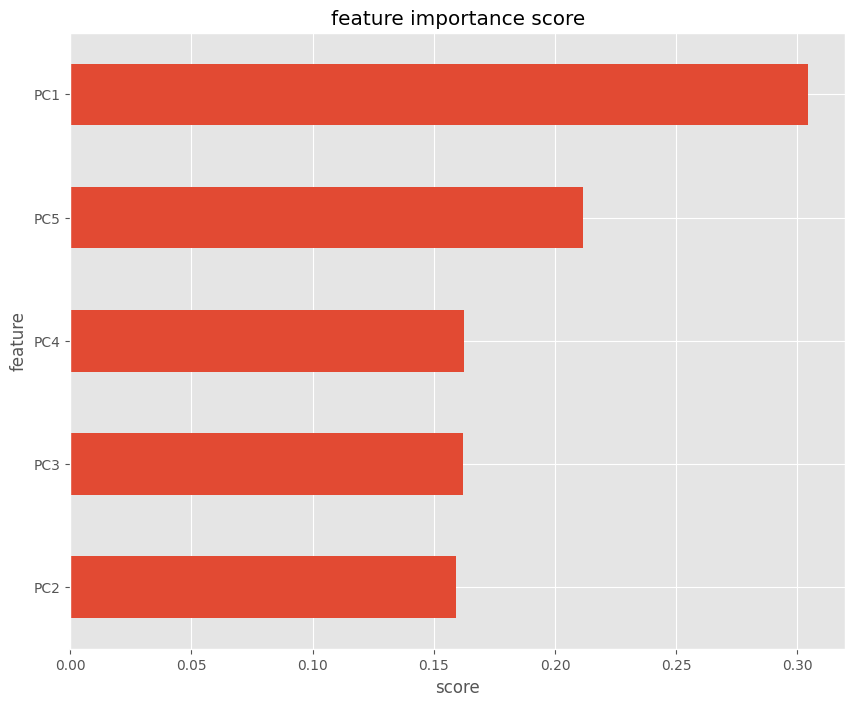

In [33]:
show_feature_importance(xg_tuned.best_estimator_)

## Adaboost

RUMPANG 20 : AdaBoost

Menggunakan model ML AdaBoost, tampilkan hasil classification pertamanya.

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)

# Evaluasi
eval_classification(ab)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.64
Recall (Test Set): 0.14
F1-Score (Test Set): 0.23
roc_auc (test-proba): 0.60
roc_auc (train-proba): 0.75


In [35]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 500)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],
                       algorithm = ['SAMME','SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='recall')
ab_tuned.fit(X_train ,y_train)

# Predict & Evaluation
eval_classification(ab_tuned)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.65
Recall (Test Set): 0.12
F1-Score (Test Set): 0.21
roc_auc (test-proba): 0.64
roc_auc (train-proba): 0.75


Setelah dilakukan hyperparameter tuning nilai recall menurun

# Shap Decision Tree

In [36]:
!pip install shap

In [37]:
from sklearn.tree import DecisionTreeClassifier
import shap
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
shap_values = shap.TreeExplainer(dt).shap_values(X_test)

In [38]:
print(type(shap_values))
if isinstance(shap_values, list):
    print("Jumlah kelas:", len(shap_values))
    print("shap_values[0].shape:", shap_values[0].shape)
    print("shap_values[1].shape:", shap_values[1].shape)
else:
    print("shap_values.shape:", shap_values.shape)

print("X_test.shape:", X_test.shape)

<class 'numpy.ndarray'>
shap_values.shape: (4521, 5, 2)
X_test.shape: (4521, 5)


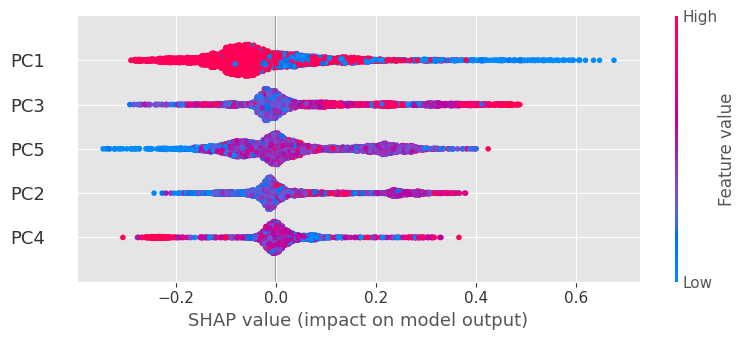

In [39]:
# Ambil shap value untuk kelas 1 (positif)
shap_values_class1 = shap_values[:, :, 1]

# Buat summary plot
shap.summary_plot(shap_values_class1, X_test)


In [40]:
explainer = shap.TreeExplainer(dt)
shap.initjs()

# SHAP values untuk sample ke-0 dan kelas 1
sample_index = 0
shap_values_for_sample = shap_values[sample_index, :, 1]

# Force plot
shap.force_plot(explainer.expected_value[1], shap_values_for_sample, X_test.iloc[sample_index, :])